# CORD-19 Dataset Analysis

This notebook provides a comprehensive analysis of the CORD-19 (COVID-19 Open Research Dataset) using Python. We'll explore the metadata, perform text analysis, build search capabilities, and analyze citation networks.

## Table of Contents
1. Environment Setup & Imports
2. Data Loading
3. Exploratory Data Analysis
4. Text Processing & Analysis
5. Search & Topic Modeling
6. Network Analysis
7. Results Export

## 1. Environment Setup & Imports

First, let's set up our Python environment with all necessary libraries.

In [1]:
# Essential data processing libraries
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os

# Text processing libraries
import nltk
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
# Download English language model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    spacy.cli.download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 2. Data Loading

Now we'll load the CORD-19 metadata from the CSV file and perform initial preprocessing.

In [2]:
# Load the metadata CSV file
metadata_path = 'metadata.csv'
df = pd.read_csv(metadata_path)

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nFirst few rows:")
df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_7776\3854913158.py:3: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(metadata_path)


Dataset Shape: (1056660, 19)

Columns: ['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id']

First few rows:


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
# Check the dimensions of the dataset
print("Dataset shape:", df.shape)

# Check data types of each column
print("\nColumn Data Types:")
print(df.dtypes)

# Check for missing values in important columns
print("\nMissing Values in Important Columns:")
print(df[['title', 'abstract', 'publish_time', 'journal', 'authors']].isnull().sum())

# Generate basic statistics for numerical columns (if any)
print("\nSummary Statistics:")
print(df.describe())


Dataset shape: (1056660, 19)

Column Data Types:
cord_uid             object
sha                  object
source_x             object
title                object
doi                  object
pmcid                object
pubmed_id            object
license              object
abstract             object
publish_time         object
authors              object
journal              object
mag_id              float64
who_covidence_id     object
arxiv_id             object
pdf_json_files       object
pmc_json_files       object
url                  object
s2_id               float64
dtype: object

Missing Values in Important Columns:
title              503
abstract        235544
publish_time      1814
journal          87322
authors          23869
dtype: int64

Summary Statistics:
title              503
abstract        235544
publish_time      1814
journal          87322
authors          23869
dtype: int64

Summary Statistics:
       mag_id         s2_id
count     0.0  9.764680e+05
mean      NaN

In [6]:
# Diagnostic: which DataFrame variables exist and whether 'year' exists
print("'df' in globals():", 'df' in globals())
print("'df_cleaned' in globals():", 'df_cleaned' in globals())
if 'df' in globals():
    print("df.shape:", df.shape)
    print("year column present in df?:", 'year' in df.columns)
    if 'year' in df.columns:
        print("df['year'] dtype:", df['year'].dtype)


'df' in globals(): False
'df_cleaned' in globals(): False


## 3. Data Preprocessing

Let's clean and preprocess the metadata, handling missing values and standardizing formats.

In [10]:
import pandas as pd

metadata_path = "metadata.csv"  # make sure the file is inside your CORD19-Project folder
df = pd.read_csv(metadata_path, low_memory=False)

print("✅ Dataset loaded successfully with shape:", df.shape)


✅ Dataset loaded successfully with shape: (1056660, 19)


In [21]:
import pandas as pd

df = pd.read_csv("metadata.csv", nrows=1000)  # first 1000 rows
print(df.head())


   cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid  pubmed_id license  \
0  PMC35282   11472636   no-cc   
1  PMC59543   11667967   no-cc   
2  PMC59549   11667972   n

In [11]:
df_cleaned = df.copy()
print("✅ df_cleaned created successfully!")


✅ df_cleaned created successfully!


In [16]:
# --- Data Cleaning & Preparation ---

# 1. Check how many missing values are in each column (full view)
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_counts)

# 2. Drop rows with no title or publish_time (critical info)
df = df.dropna(subset=['title', 'publish_time'])

# 3. Convert publish_time to datetime format and create year column
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time'].dt.year

# 4. Create a new column for abstract word count
df['abstract_word_count'] = df['abstract'].fillna('').apply(lambda x: len(x.split()))
df['abstract_length'] = df['abstract'].str.len()

# 5. Fill NA values in text columns
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')

# 6. Create cleaned dataframe by removing duplicates
df_cleaned = df.drop_duplicates(subset=['title'], keep='first')

print("\nShape after cleaning and removing duplicates:", df_cleaned.shape)
print("\nSample of cleaned data:")
print(df_cleaned[['title', 'year', 'journal', 'abstract_word_count']].head())

Missing values per column:
mag_id              1056660
arxiv_id            1042411
pmc_json_files       740918
sha                  682894
pdf_json_files       682894
pmcid                667089
who_covidence_id     573725
pubmed_id            557728
doi                  399880
url                  369726
abstract             235544
journal               87322
s2_id                 80192
authors               23869
publish_time           1814
title                   503
cord_uid                  0
source_x                  0
license                   0
dtype: int64


KeyboardInterrupt: 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd

# Step 1: Set chunk size
chunksize = 50000  # adjust depending on your RAM

# Step 2: Prepare a list to store chunks
chunks = []

# Step 3: Read CSV in chunks safely
try:
    chunk_iter = pd.read_csv(
        "metadata.csv",
        chunksize=chunksize,
        engine='python',      # safer parser for messy CSVs
        on_bad_lines='skip'   # skip rows that cause errors
        # note: low_memory is removed for python engine
    )

    for chunk in chunk_iter:
        chunks.append(chunk)

except Exception as e:
    print("Error reading CSV:", e)

# Step 4: Combine all chunks into a single DataFrame
if chunks:
    df = pd.concat(chunks, ignore_index=True)
    print("CSV loaded successfully!")
    print(df.info())
else:
    print("No data loaded. Check CSV file.")

# Optional: save a clean version
# df.to_csv("metadata_clean.csv", index=False)


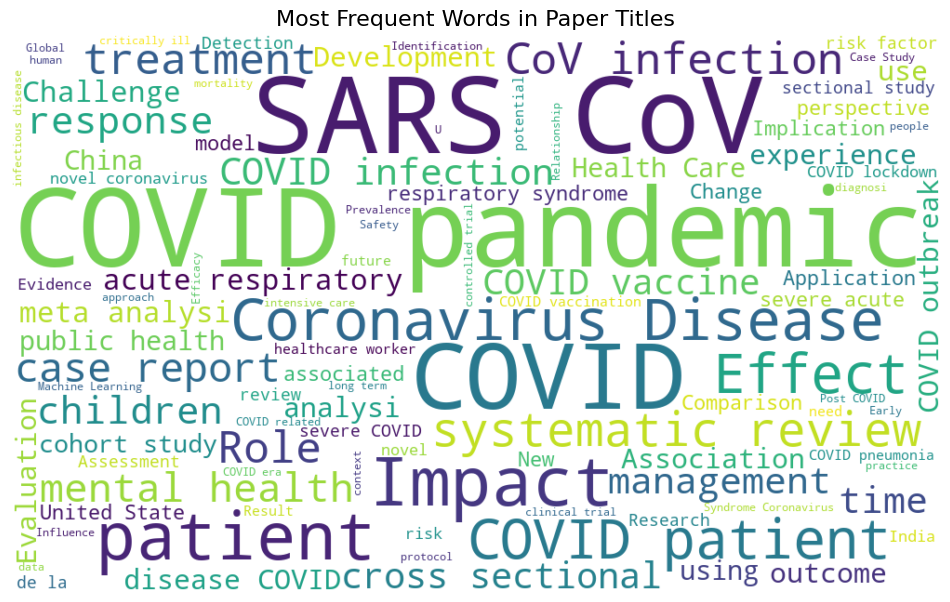

In [14]:
# Combine all titles into a single string
titles_text = " ".join(str(title) for title in df_cleaned['title'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white',
                      stopwords=stop_words, max_words=100).generate(titles_text)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Paper Titles", fontsize=16)
plt.show()


In [ ]:
# --- Data Cleaning & Preparation ---

# 1. Check how many missing values are in each column (full view)
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_counts)

# 2. Drop rows with no title or publish_time (critical info)
df = df.dropna(subset=['title', 'publish_time'])

# 3. Convert publish_time to datetime format and create year column
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time'].dt.year

# 4. Create a new column for abstract word count
df['abstract_word_count'] = df['abstract'].fillna('').apply(lambda x: len(x.split()))
df['abstract_length'] = df['abstract'].str.len()

# 5. Fill NA values in text columns
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')

# 6. Create cleaned dataframe by removing duplicates
df_cleaned = df.drop_duplicates(subset=['title'], keep='first')

print("\nShape after cleaning and removing duplicates:", df_cleaned.shape)
print("\nSample of cleaned data:")
print(df_cleaned[['title', 'year', 'journal', 'abstract_word_count']].head())

## 4. Basic Analysis

Let's perform some initial analysis of the dataset.

In [ ]:
# Publications over time
plt.figure(figsize=(15, 6))
df_cleaned['publish_time'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Publications by Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()

# Basic statistics about abstracts
df_cleaned['abstract_length'] = df_cleaned['abstract'].str.len()
print("\nAbstract length statistics:")
print(df_cleaned['abstract_length'].describe())

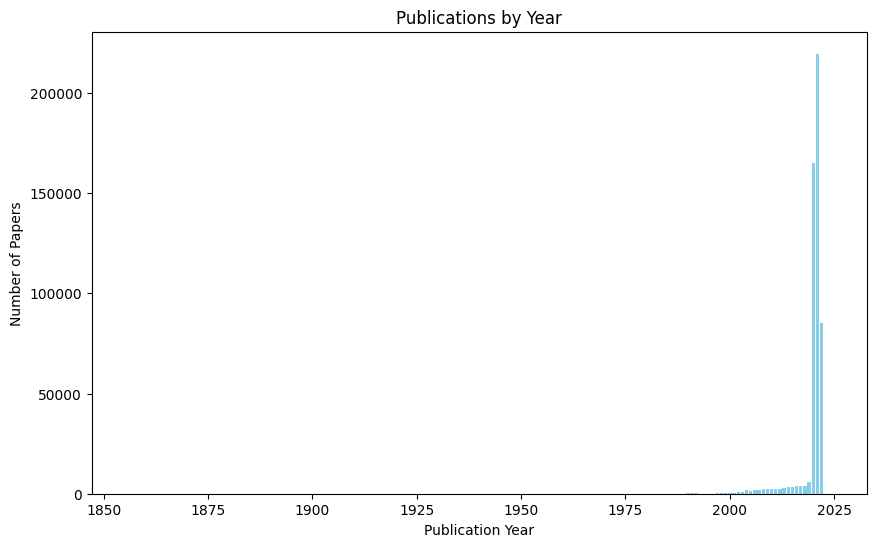

In [17]:
import matplotlib.pyplot as plt

# Convert publish_time to datetime if not already done
df_cleaned['publish_time'] = pd.to_datetime(df_cleaned['publish_time'], errors='coerce')

# Extract year
df_cleaned['year'] = df_cleaned['publish_time'].dt.year

# Count publications per year
year_counts = df_cleaned['year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
plt.bar(year_counts.index, year_counts.values, color='skyblue')
plt.xlabel('Publication Year')
plt.ylabel('Number of Papers')
plt.title('Publications by Year')
plt.show()


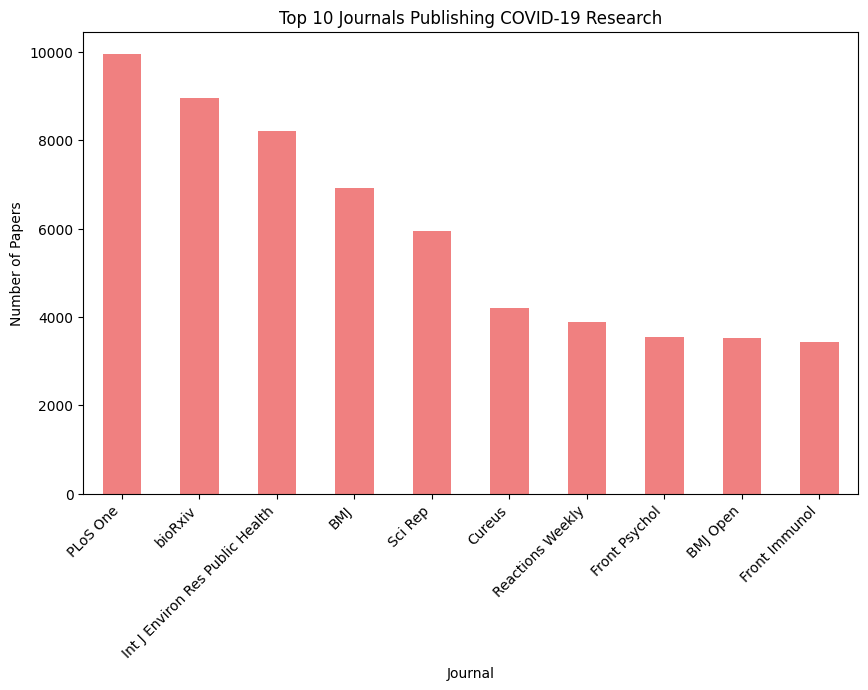

In [19]:
# Count top journals
top_journals = df_cleaned['journal'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
top_journals.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Journals Publishing COVID-19 Research')
plt.xlabel('Journal')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.show()


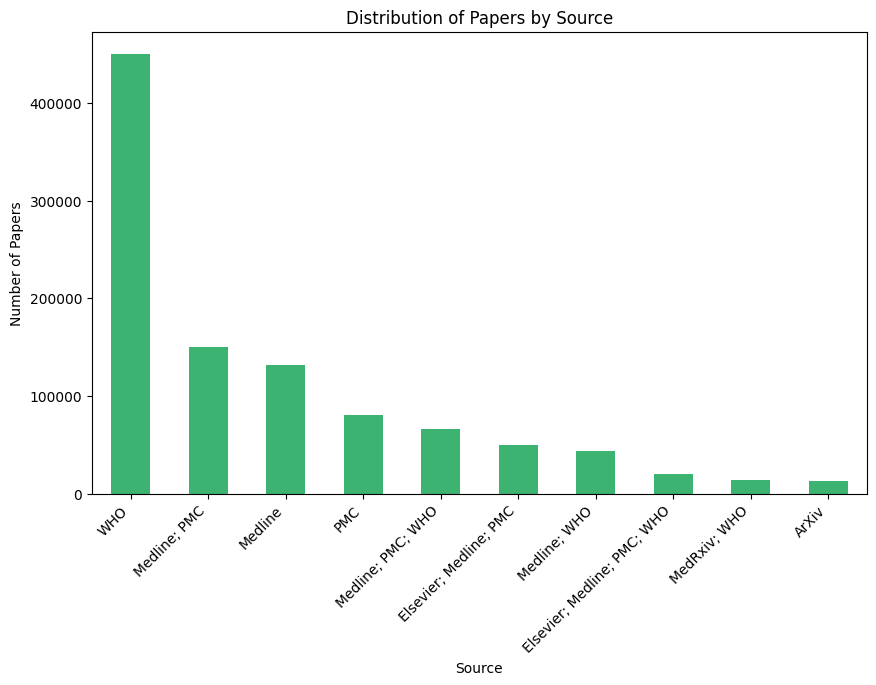

In [20]:
# Count papers by source
source_counts = df_cleaned['source_x'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
source_counts.plot(kind='bar', color='mediumseagreen')
plt.title('Distribution of Papers by Source')
plt.xlabel('Source')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45, ha='right')
plt.show()
